#### Import data

In [1]:
import pandas as pd

df = pd.read_csv('data/us.csv')
df.head()

,DATE,GDP,GDP_QoQ,GDP_YoY,REAL_GDP_QoQ,REAL_GDP_YoY,SP,PERC_SP,SP_VOL,PERC_SP_VOL,M2,M2_MoM,NEW_M2,NEW_M2_MoM,DEBT_AMOUNT,DEBT_AMOUNT_YoY,INFLATION,CORE_INFLATION,UNEMPLOYMENT_RATE,RATES
0,1970-01-01,1051.2,NaN,NaN,-0.6,0.32493,NaN,NaN,NaN,NaN,589.6,NaN,NaN,NaN,NaN,NaN,6.16246,6.16622,3.9,5.00
1,1970-01-02,NaN,NaN,NaN,NaN,NaN,93.000000,NaN,8050000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.63
2,1970-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.63
3,1970-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.63
4,1970-01-05,NaN,NaN,NaN,NaN,NaN,93.459999,0.494623,11490000.0,42.732919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.75


### Importance of time metrics - GDP

#### Time metrics

Taking only GDP data

In [2]:
gdps = df[['DATE', 'GDP', 'GDP_QoQ', 'GDP_YoY', 'REAL_GDP_QoQ', 'REAL_GDP_YoY']].copy()
gdps['DATE'] = pd.to_datetime(gdps['DATE'])
gdps.dropna(inplace=True)

# Remove covid data (outliers)
gdps = gdps[gdps['DATE'] < '2020-01-01']
# And 1970  (nominal QoQ and YoY is missing)
gdps = gdps[gdps['DATE'] > '1970-10-01']

print(gdps.isna().sum())
gdps.reset_index(drop=True, inplace=True)
gdps.head()

DATE            0
GDP             0
GDP_QoQ         0
GDP_YoY         0
REAL_GDP_QoQ    0
REAL_GDP_YoY    0
dtype: int64


,DATE,GDP,GDP_QoQ,GDP_YoY,REAL_GDP_QoQ,REAL_GDP_YoY
0,1971-01-01,1135.156,4.275919,7.986682,11.3,2.69724
1,1971-04-01,1156.271,1.860097,8.328469,2.2,3.10661
2,1971-07-01,1177.675,1.851123,8.435637,3.3,3.00589
3,1971-10-01,1190.297,1.071773,9.341195,1.0,4.36720
4,1972-01-01,1230.609,3.386718,8.408800,7.6,3.47607


##### First, we will make the dataset (2 cells)

Function to calculate the influence in a year with respect to its percentage change

In [3]:
def quarter_influence(df, column, new_column_name):
    """
    ONLY MADE TO CALCULATE WITH PERCENTAGES (QoQ, YoY, etc.)

    Return the percentaje of GROWTH-influence to each quarter in a year.
    Results could be negative.

    Example 1 (annual growth):
     'DATE': ['2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01']
     'Value': [-1,  1,  2,  2]
      Result: [-25, 25, 50, 50] <- (cumsum = 100%)
    Example 2 (annual decrease):
        'DATE': ['2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01']
        'Value': [-2,  -2,  1,  1]
        Result: [-100, -100, 50, 50] <- (cumsum = -100%)
    """
    df = df.copy()
    df['DATE'] = pd.to_datetime(df['DATE'])
    df[new_column_name] = float('NaN')
    # Just in our case, we have 4 quarters per year:
    for i in range(0, len(df), 4):
        quarters_year_sum = df.loc[i:i+3, column].sum()
        for j in range(i, i+4):
            if quarters_year_sum < 0:
                df.at[j, new_column_name] = (df.at[j, column] / quarters_year_sum) * (-100)
            elif quarters_year_sum > 0:
                df.at[j, new_column_name] = (df.at[j, column] / quarters_year_sum) * 100
            else:
                print("What a coincidence! The sum of the quarters is 0")
                return None
    return df

Use the last function to get a dataframe with GDP and the influence of each year

In [4]:
df_quarter_rate = gdps.copy()

# Apply last func to desired columns
cols_to_aply = ['GDP_QoQ', 'GDP_YoY', 'REAL_GDP_QoQ', 'REAL_GDP_YoY']
naming_cols = ['GDP_QoQ_YEAR_INFLUENCE', 'GDP_YoY_YEAR_INFLUENCE', 'REAL_GDP_QoQ_YEAR_INFLUENCE', 'REAL_GDP_YoY_YEAR_INFLUENCE']
for col, name in zip(cols_to_aply, naming_cols):
    df_quarter_rate = quarter_influence(df_quarter_rate, col, name)

# Reorder columns
df_quarter_rate = df_quarter_rate[["DATE", "GDP",
                                   "GDP_QoQ", "GDP_QoQ_YEAR_INFLUENCE",
                                   "GDP_YoY", "GDP_YoY_YEAR_INFLUENCE",
                                   "REAL_GDP_QoQ", "REAL_GDP_QoQ_YEAR_INFLUENCE",
                                   "REAL_GDP_YoY", "REAL_GDP_YoY_YEAR_INFLUENCE"]]
# We will use this calc ('x_YEAR_INFLUENCE') in the boxplot
df_quarter_rate.head(4)

,DATE,GDP,GDP_QoQ,GDP_QoQ_YEAR_INFLUENCE,GDP_YoY,GDP_YoY_YEAR_INFLUENCE,REAL_GDP_QoQ,REAL_GDP_QoQ_YEAR_INFLUENCE,REAL_GDP_YoY,REAL_GDP_YoY_YEAR_INFLUENCE
0,1971-01-01,1135.156,4.275919,47.201246,7.986682,23.426861,11.3,63.483146,2.69724,20.469396
1,1971-04-01,1156.271,1.860097,20.533335,8.328469,24.429406,2.2,12.359551,3.10661,23.576111
2,1971-07-01,1177.675,1.851123,20.434277,8.435637,24.743756,3.3,18.539326,3.00589,22.811745
3,1971-10-01,1190.297,1.071773,11.831142,9.341195,27.399976,1.0,5.617978,4.36720,33.142748


Average values for each quarter (*pie chart*)

In [5]:
# Data by quarter
quarter1 = df_quarter_rate[df_quarter_rate['DATE'].dt.strftime('%m-%d') == '01-01']
quarter2 = df_quarter_rate[df_quarter_rate['DATE'].dt.strftime('%m-%d') == '04-01']
quarter3 = df_quarter_rate[df_quarter_rate['DATE'].dt.strftime('%m-%d') == '07-01']
quarter4 = df_quarter_rate[df_quarter_rate['DATE'].dt.strftime('%m-%d') == '10-01']

# Naming vars
means_QoQ, means_YoY = [], []
quarters = [quarter1, quarter2, quarter3, quarter4]

# Average of each quarter
for i in range(4):
    quarter = quarters[i]
    means_QoQ.append(quarter['GDP_QoQ'].mean())
    means_YoY.append(quarter['GDP_YoY'].mean())

print(means_QoQ, '   <- Quarters means QoQ')
print(means_YoY, '    <- Quarters means YoY')

# Make df to plot
data_plot = pd.DataFrame({'Quarter': ['Q1', 'Q2', 'Q3', 'Q4'],
                          'Mean_QoQ': means_QoQ,
                          'Mean_YoY': means_YoY})
data_plot

[1.483442951084814, 1.6600953546745683, 1.519839997897151, 1.5093997920523547]    <- Quarters means QoQ
[6.348721291862436, 6.343075641772376, 6.332382936223568, 6.341768177741289]     <- Quarters means YoY


,Quarter,Mean_QoQ,Mean_YoY
0,Q1,1.483443,6.348721
1,Q2,1.660095,6.343076
2,Q3,1.519840,6.332383
3,Q4,1.509400,6.341768


##### Pie chart

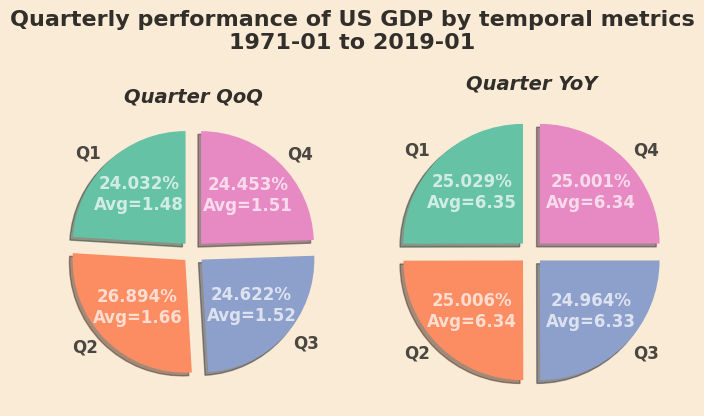

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Quarterly performance of US GDP by temporal metrics\n1971-01 to 2019-01', fontsize=16,
              fontweight='bold', y=1.10, alpha=0.8)

# Pie chart for Mean_QoQ, select data, add slice, decimals, etc.
wedges1, texts1, autotexts1 = ax1.pie(data_plot['Mean_QoQ'], labels=data_plot['Quarter'],
        autopct='%1.3f%%', shadow=True, startangle=90, colors=sns.color_palette("Set2"), explode=(0.1, 0.1, 0.1, 0.1))

# Add Mean_QoQ values below the percentages
for i, autotext in enumerate(autotexts1):
    autotext.set(size=12, fontweight='bold', alpha=0.7, color='white')
    autotext.set_text(f"{autotext.get_text()}\nAvg={data_plot['Mean_QoQ'][i]:.2f}")
    texts1[i].set(size=12, fontweight='bold', alpha=0.7)

# Add title to ax1
ax1.set_title('Quarter QoQ', fontweight='bold', fontsize=14, fontstyle='italic', alpha=0.8)

# Mean_YoY pie chart
wedges2, texts2, autotexts2 = ax2.pie(data_plot['Mean_YoY'], labels=data_plot['Quarter'],
        autopct='%1.3f%%', shadow=True, startangle=90, colors=sns.color_palette("Set2"), explode=(0.1, 0.1, 0.1, 0.1))

# Same for Mean_YoY
for i, autotext in enumerate(autotexts2):
    autotext.set(size=12, fontweight='bold', alpha=0.7, color='white')
    autotext.set_text(f"{autotext.get_text()}\nAvg={data_plot['Mean_YoY'][i]:.2f}")
    texts2[i].set(size=12, fontweight='bold', alpha=0.7)

# This gives a ax2 bigger size, i just liked, not based on anything
# Just bigger numbers bigger size
ax2.axis('equal')

ax2.set_title('Quarter YoY', fontweight='bold', fontsize=14, fontstyle='italic', alpha=0.8)
fig.patch.set_facecolor('antiquewhite')

# Draw before to avoid blank image
plt.draw()
plt.savefig('images/GDP_measures.png', bbox_inches='tight')
plt.show()

#### NOMINAL VS REAL METRICS

Boxplot

In [7]:
import plotly.express as px

# Get df, date and rename columns
df_ploty = df_quarter_rate.copy()
df_ploty['DATE'] = pd.to_datetime(df_ploty['DATE'])
# It is necessary to rename just this 2 columns
# as we will use same var 'Variable' to plot on Y axis
# And this names will apper in the legend
df_ploty.rename(columns={'REAL_GDP_YoY': 'Real GDP', 'GDP_YoY': 'Nominal GDP'}, inplace=True)
# Add a quarter column
df_ploty['Quarter'] = df_ploty['DATE'].dt.quarter

# Create 2 sources of data, one per GDP type (2 boxes)
combined_data = pd.concat([
    df_ploty[['Quarter', 'Nominal GDP', 'GDP_YoY_YEAR_INFLUENCE', 'DATE']].rename(
        columns={'Nominal GDP': 'Value', 'GDP_YoY_YEAR_INFLUENCE': 'One-Year Growth Participation'}),
    df_ploty[['Quarter', 'Real GDP', 'REAL_GDP_YoY_YEAR_INFLUENCE', 'DATE']].rename(
        columns={'Real GDP': 'Value', 'REAL_GDP_YoY_YEAR_INFLUENCE': 'One-Year Growth Participation'})
        ])

# Column ('Type') indicates if it is GDP o REAL_GDP
combined_data['Type'] = ['Nominal GDP'] * len(df_ploty) + ['Real GDP'] * len(df_ploty)
combined_data['YEAR'] = combined_data['DATE'].dt.year
# 2 decimals places
combined_data['One-Year Growth Participation'] = combined_data['One-Year Growth Participation'].apply(lambda x: f'{x:.2f}%')
# As 'Value' is needed to axis Y and can't be a string, copy and add "%" for hover_data
combined_data['Value_Label'] = combined_data['Value'].apply(lambda x: f'{x:.2f}%')

fig = px.box(combined_data, x='Quarter', y='Value', color='Type', color_discrete_map={'Nominal GDP': 'deepskyblue', 'Real GDP': 'darkorange'},
             title='<b>Interactive chart</b><br><b>Exploring U.S. GDP: Nominal vs Real Comparison (1971 Q1 - 2019 Q4) - YoY</b>',
             labels={'YEAR': 'Year', 'Quarter': 'Quarter', 'Value_Label': 'Percent Change YoY'},
             category_orders={'Quarter': sorted(df_ploty['Quarter'].unique())},
             points='all',
             hover_data={'YEAR': ':d', 'Quarter': False, 'One-Year Growth Participation': True,
                         'Value_Label': True, 'Value': False, 'Type': False},
             range_y=[-4.5, 15], range_x=[0.5, 4.4])

fig.write_html('images/Quarterly_Dynamics_YoY.html')
fig.show()

#### Why should we use nominal or real. In numbers:

Function to generate inflation/deflation tables

In [8]:
def max_diff (df, column1, column2,n=5, reaname_col1=False, reaname_col2=False):
    """
    Return a DF with 2 new columns:
    - The difference between column1 and column2.
    - How many times column1 is greater or lower than column2.
    """
    df = df.copy()
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df[["DATE", column1, column2]]
    df['DIFFERENCE'] = df[column1] - df[column2]
    df['x TIMES'] = df.apply(lambda row: row[column1] / row[column2] if row[column2] != 0 else 0, axis=1)
    df['CHANGE (%)'] = df.apply(lambda row: ((row[column1] - row[column2]) / row[column2]) * 100 if row[column2] != 0 else 0, axis=1)
    # If column 2 (real expected) is greater than column 1,
    # CHANGE (%) will be negative, (so inflation = '+' and deflation = '-')
    for i in range(len(df)):
        if df.at[i, column1] > df.at[i, column2]:
            df.at[i, 'CHANGE (%)'] = abs(df.at[i, 'CHANGE (%)']) 
        else:
            df.at[i, 'CHANGE (%)'] = abs(df.at[i, 'CHANGE (%)']) * -1
    # Return the top N or bottom N depending on 'n' value
    if n > 0:
        result_df = df.sort_values(by='CHANGE (%)', ascending=False).head(n)
    elif n < 0:
        result_df = df.sort_values(by='CHANGE (%)', ascending=True).head(-n)
    else:
        print("'n' value must be different from 0")
        return None
    # From the top N, columns renamed
    if reaname_col1:
        result_df.rename(columns={column1: reaname_col1}, inplace=True)
        result_df[reaname_col1] = result_df[reaname_col1].apply(lambda x: f'{x:.2f}')
    else:
        result_df[column1] = result_df[column1].apply(lambda x: f'{x:.2f}')
    
    if reaname_col2:
        result_df.rename(columns={column2: reaname_col2}, inplace=True)
        result_df[reaname_col2] = result_df[reaname_col2].apply(lambda x: f'{x:.2f}')
    else:
        result_df[column2] = result_df[column2].apply(lambda x: f'{x:.2f}')

    # Make 2 decimals and add '%' now that is ordered
    result_df['CHANGE (%)'] = result_df['CHANGE (%)'].apply(lambda x: f'{x:.2f} %')
    result_df['DIFFERENCE'] = result_df['DIFFERENCE'].apply(lambda x: f'{x:.2f}')
    result_df['x TIMES'] = result_df['x TIMES'].apply(lambda x: f'{x:.2f}')

    return result_df


max_diff(df_quarter_rate, 'GDP_YoY', 'REAL_GDP_YoY', n=6, reaname_col1='GDP YoY', reaname_col2='REAL GDP YoY')

,DATE,GDP YoY,REAL GDP YoY,DIFFERENCE,x TIMES,CHANGE (%)
39,1980-10-01,9.61,-0.04,9.65,-245.51,24650.61 %
13,1974-04-01,8.22,-0.21,8.42,-39.42,4042.18 %
82,1991-07-01,3.17,-0.10,3.28,-30.88,3188.35 %
14,1974-07-01,8.80,-0.63,9.43,-13.99,1499.16 %
12,1974-01-01,8.26,0.64,7.62,12.92,1192.41 %
123,2001-10-01,2.15,0.17,1.98,12.62,1161.94 %


TABLES HTML - GDP INFLATION

In [9]:
df_gdp_inflation = df[['DATE', 'GDP', 'GDP_QoQ', 'GDP_YoY', 'REAL_GDP_QoQ', 'REAL_GDP_YoY']].copy()  # 1971-Q1 to 2023-Q2
df_gdp_inflation.dropna(inplace=True)
df_gdp_inflation.reset_index(drop=True, inplace=True)

# Print table to copy-paste in html or save it. Your choice
# Max difference between GDP and REAL_GDP (YoY):
#print(max_diff(df_gdp_inflation, 'GDP_YoY', 'REAL_GDP_YoY', n=5, reaname_col1='GDP YoY', reaname_col2='REAL GDP YoY').to_html(index=False, classes='styled-table'))

In [10]:
# Min difference between GDP and REAL_GDP (YoY):
#print(max_diff(df_gdp_inflation, 'GDP_YoY', 'REAL_GDP_YoY', n=-5, reaname_col1='GDP YoY', reaname_col2='REAL GDP YoY').to_html(index=False, classes='styled-table'))

If YoY is used, there is no single deflationary value. What if QoQ is used?

In [11]:
# 155 values where CHANGE (%) is negative (deflation)
max_diff(df_gdp_inflation, 'GDP_QoQ', 'REAL_GDP_QoQ', n=-166, reaname_col1='GDP QoQ', reaname_col2='REAL GDP QoQ').reset_index(drop=True)

,DATE,GDP QoQ,REAL GDP QoQ,DIFFERENCE,x TIMES,CHANGE (%)
0,2016-01-01,0.51,2.40,-1.89,0.21,-78.81 %
1,2015-10-01,0.14,0.60,-0.46,0.23,-77.13 %
2,2015-01-01,0.78,3.30,-2.52,0.24,-76.44 %
3,2020-07-01,8.79,35.30,-26.51,0.25,-75.10 %
4,2011-10-01,1.24,4.60,-3.36,0.27,-72.97 %
...,...,...,...,...,...,...
161,1982-04-01,1.76,1.80,-0.04,0.98,-2.15 %
162,1979-07-01,2.95,3.00,-0.05,0.98,-1.83 %
163,2012-07-01,0.69,0.70,-0.01,0.99,-0.92 %
164,1990-04-01,1.49,1.50,-0.01,0.99,-0.87 %


Calculation of the average error

In [12]:
# Error nominal-real (YoY)
make_avg = max_diff(df_gdp_inflation, 'GDP_YoY', 'REAL_GDP_YoY', n=366, reaname_col1='GDP QoQ', reaname_col2='REAL GDP QoQ').reset_index(drop=True)
make_avg['x TIMES'] = make_avg['x TIMES'].astype(float)
# Outlier
make_avg.drop(make_avg[make_avg['DATE'] == '1980-10-01'].index, inplace=True)
make_avg['x TIMES'] = abs(make_avg['x TIMES'])
print("Average error percentage of x TIMES: ", make_avg['x TIMES'].mean())



Average error percentage of x TIMES:  2.860717703349282


#### Differences in practice - Last case GDP analysis

Get all GDP data

In [13]:
# Name df to use in the next cell
df_gdp_to_plot = df[['DATE', 'GDP', 'GDP_QoQ', 'GDP_YoY', 'REAL_GDP_QoQ', 'REAL_GDP_YoY']].copy()
df_gdp_to_plot['DATE'] = pd.to_datetime(df_gdp_to_plot['DATE'])
df_gdp_to_plot = df_gdp_to_plot.dropna()
df_gdp_to_plot['Quarter'] = df_gdp_to_plot['DATE'].dt.quarter

all_gdp = df_gdp_to_plot.copy()

Plot - Metrics in practice

In [14]:
import plotly.subplots as sp
import plotly.graph_objs as go

fig2 = sp.make_subplots(rows=2, cols=2, subplot_titles=('<b>GDP QoQ</b>', '<b>GDP YoY</b>', '<b>Real GDP QoQ</b>', '<b>Real GDP YoY</b>'))
colors = ['rgb(0, 191, 255)', 'rgb(255, 165, 0)', 'rgb(111, 111, 111)', 'rgb(144, 238, 144)']
legend_groups_tittle = ['GDP QoQ', 'GDP YoY', 'Real GDP QoQ', 'Real GDP YoY']

for i, metric in enumerate(['GDP_QoQ', 'GDP_YoY', 'REAL_GDP_QoQ', 'REAL_GDP_YoY']):
    # Set row and col subplots
    row = 1 if i < 2 else 2
    col = i % 2 + 1

    # Draw lines for each quarter
    for quarter in range(1, 5):
        trace = go.Scatter(x=all_gdp[all_gdp['DATE'].dt.quarter == quarter]['DATE'],
                           y=all_gdp[all_gdp['DATE'].dt.quarter == quarter][metric],
                           mode='lines',
                           name=f'Q{quarter}',
                           line=dict(color=colors[quarter-1]),
                           showlegend=True,
                           legendgroup=legend_groups_tittle[i],
                           legendgrouptitle=dict(text=legend_groups_tittle[i]))
        # Negative quarters to plot count. Example: Q1 (5)
        trace['name'] += f' ({len(all_gdp[(all_gdp["DATE"].dt.quarter == quarter) & (all_gdp[metric] < 0)])})'
        
        fig2.add_trace(trace, row=row, col=col)
        # If there is a negative value, draw a red marker
        fig2.add_trace(go.Scatter(x=all_gdp[(all_gdp['DATE'].dt.quarter == quarter) & (all_gdp[metric] < 0)]['DATE'],
                                    y=all_gdp[(all_gdp['DATE'].dt.quarter == quarter) & (all_gdp[metric] < 0)][metric],
                                    mode='markers',
                                    marker=dict(color='red'),
                                    opacity=0.7,
                                    name=f'Q{quarter} negative',
                                    showlegend=False),
                        row=row, col=col)
    
        # Set date values to see if there are consecutive negatives
        consecutive_negatives = []
        count = 0
        for index, row_data in all_gdp.iterrows():
            if row_data[metric] < 0:
                count += 1
                if count == 1:
                    first_neg = row_data['DATE']
                if count >= 2:
                    last_neg = row_data['DATE']
            else:
                if count >= 2:
                    consecutive_negatives.append((first_neg, last_neg))
                if count == 1:
                    # If there is only one negative, draw a red line
                    fig2.add_shape(type='rect', x0=first_neg, y0=-40, x1=first_neg, y1=40,
                                    line=dict(color='red', width=1),
                                    fillcolor='red',
                                    opacity=0.10,
                                    row=row, col=col)
                count = 0
            
        # But if there are consecutive negatives (2 or more), draw a green line
        for start_date, end_date in consecutive_negatives:
            fig2.add_shape(type='rect',
                            x0=start_date, y0=-40, x1=end_date, y1=40,
                            line=dict(color='green', width=2),
                            fillcolor='green',
                            opacity=0.10,
                            row=row, col=col)

# Custom
fig2.update_layout(title_text='<b>Comparative Examination of U.S. GDP through various Measures</b><br>(1971 Q1 - 2023 Q2)', title_y=0.95)
fig2.update_yaxes(title_text='Percent (%)', row=1, col=1)
fig2.update_xaxes(title_text='Date', row=2, col=1)
fig2.update_yaxes(title_text='Percent (%)', row=2, col=1)
fig2.update_xaxes(title_text='Date', row=2, col=2)
fig2.update_xaxes(range=['1971-01-01', '2023-04-01'])
# Use different zoom for each plot
fig2.update_yaxes(range=[-10, 10], row=1, col=1)
fig2.update_yaxes(range=[-10, 19], row=1, col=2)
fig2.update_yaxes(range=[-33, 38], row=2, col=1)
fig2.update_yaxes(range=[-10, 14], row=2, col=2)
fig2.update_layout(plot_bgcolor='antiquewhite')
fig2.update_layout(height=750, width=1100)

fig2.write_html('images/Comparative_measures_GDP.html')
fig2.show()

### FEDERAL RESERVE DECISIONS:

##### Correlation Matrix - Inflation

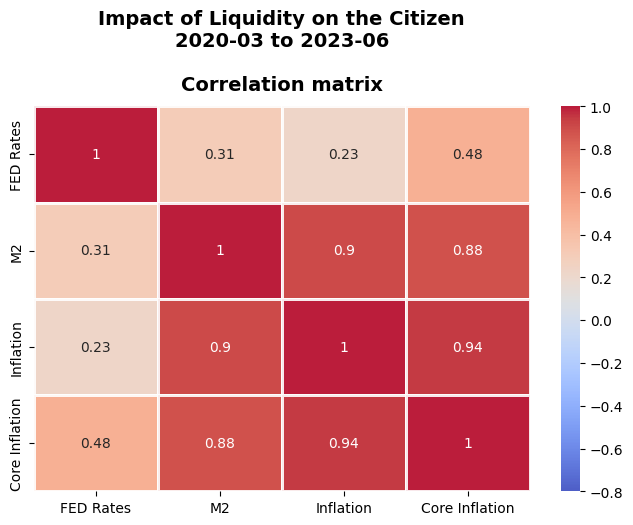

In [15]:
citizen = df[['DATE', 'RATES', 'NEW_M2', 'INFLATION', 'CORE_INFLATION']].copy()
citizen.dropna(inplace=True)
citizen.reset_index(drop=True, inplace=True)
# Print max and min date for title
#print(citizen['DATE'].min(), citizen['DATE'].max())
citizen.drop('DATE', axis=1, inplace=True)
test_matrix_corr = citizen.corr()

# Labels:
corr_labels = ['FED Rates', 'M2', 'Inflation', 'Core Inflation']
test_matrix_corr.columns = corr_labels
test_matrix_corr.index = corr_labels

# Plot
plt.figure(figsize=(8, 5))
sns.heatmap(test_matrix_corr, cmap='coolwarm', annot=True, alpha=0.9, linewidths=1, linecolor='white', vmin=-0.8, vmax=1)
plt.title('Impact of Liquidity on the Citizen\n2020-03 to 2023-06\n\nCorrelation matrix', fontsize=14, fontweight='bold', y=1.02)
plt.draw()
plt.savefig('images/Corr_citizen.png', bbox_inches='tight')

##### Correlation Matrix - S&P500

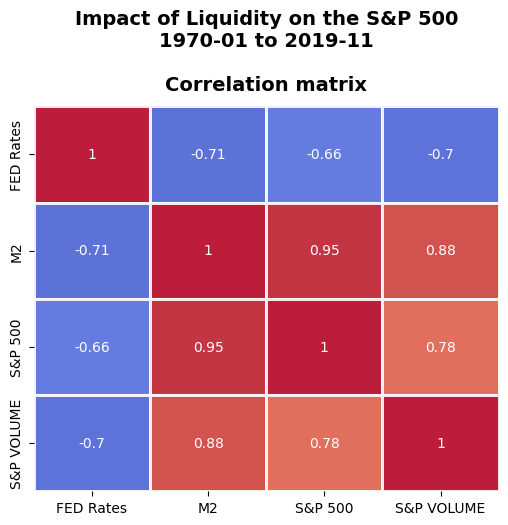

In [16]:
sp = df[['DATE', 'RATES', 'M2', 'SP', 'SP_VOL']].copy()
sp.dropna(inplace=True)
# Print as before
# print(sp['DATE'].min(), sp['DATE'].max())
sp.drop('DATE', axis=1, inplace=True)
sp_corr = sp.corr()

# Labels:
new_labels = ['FED Rates', 'M2', 'S&P 500', 'S&P VOLUME']
sp_corr.columns = new_labels
sp_corr.index = new_labels

# Plot
plt.figure(figsize=(6, 5))
# Use same scale for both plots (-0.8 to 1)
sns.heatmap(sp_corr, cmap='coolwarm', annot=True, alpha=0.9, linewidths=1, linecolor='white', vmin=-0.8, vmax=1)
# As they will be together, remove colorbar
plt.gca().collections[0].colorbar.remove()
plt.title('Impact of Liquidity on the S&P 500\n1970-01 to 2019-11\n\nCorrelation matrix', fontsize=14, fontweight='bold', y=1.02)
plt.draw()
plt.savefig('images/Corr_sp.png', bbox_inches='tight')



#### Going deeper: CPIs Vs Interest Rates

Get data

In [17]:
cpi = df[['DATE', 'RATES', 'INFLATION', 'CORE_INFLATION']].copy()
cpi.dropna(inplace=True)
cpi.reset_index(drop=True, inplace=True)
cpi.head()

,DATE,RATES,INFLATION,CORE_INFLATION
0,1970-01-01,5.00,6.16246,6.16622
1,1970-02-01,9.38,6.42458,5.85106
2,1970-03-01,8.50,6.09418,6.08466
3,1970-04-01,8.00,6.06061,6.03675
4,1970-05-01,8.63,6.04396,6.29921


Charting interest rate and inflation decisions

In [18]:
fig3 = go.Figure()

# Draw line for RATES
fig3.add_trace(go.Scatter(x=cpi['DATE'], y=cpi['RATES'], mode='lines', name='Interest Rates', legendgroup='Interest Rates',
                         hovertemplate='<b>Type:</b> Interest Rates<br><b>Date:</b> %{x}<br><b>Value:</b> %{y:.2f}<extra></extra>'))

# Draw area for Inflation
fig3.add_trace(go.Scatter(x=cpi['DATE'], y=cpi['INFLATION'], fill='tonexty', mode='none',
                         fillcolor='rgba(0, 255, 0, 0.3)', name='CPI: All Items',
                         hovertemplate='<b>Type:</b> CPI All Items<br><b>Date:</b> %{x}<br><b>Value:</b> %{y:.2f}<extra></extra>'))
# And Core Inflation
fig3.add_trace(go.Scatter(x=cpi['DATE'], y=cpi['CORE_INFLATION'], fill='tonexty', mode='none',
                         fillcolor='rgba(255, 127, 0, 0.7)', name='CPI: All Less Food & Energy', visible='legendonly',
                         hovertemplate='<b>Type:</b> CPI All Less Food & Energy<br><b>Date:</b> %{x}<br><b>Value:</b> %{y:.2f}<extra></extra>'))

# Customize chart text
fig3.update_layout(title='<b>Interactive chart<br>Interest Rate Decisions Regarding CPI<b>',
                  title_font_size=15,
                  xaxis_title='Date',
                  yaxis_title='Percent (%)',
                  yaxis_range=[-2.5, 22.5],
                  showlegend=True)

fig3.write_html('images/cpi_decisions.html')
fig3.show()

How much has the debt grown?

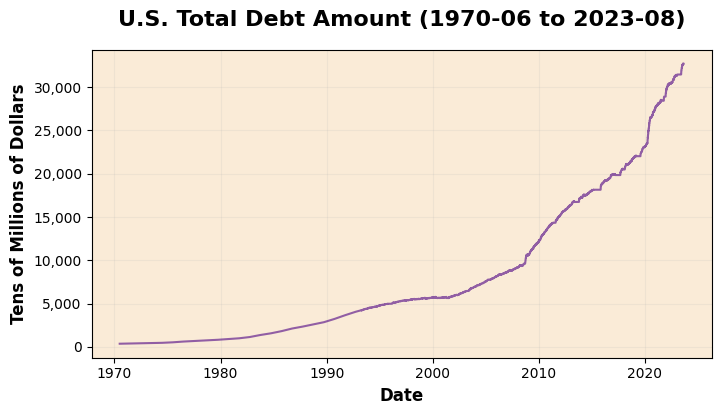

In [19]:
import matplotlib.ticker as ticker

debt = df[['DATE', 'DEBT_AMOUNT']].copy()
debt.dropna(inplace=True)
debt['DATE'] = pd.to_datetime(debt['DATE'])

plt.figure(figsize=(8, 4))
plt.title('U.S. Total Debt Amount (1970-06 to 2023-08)', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y=1.05)
# Reduce scale to millions
plt.plot(debt['DATE'], debt['DEBT_AMOUNT']/1e9, color='indigo', alpha=0.6)
plt.ylabel('Tens of Millions of Dollars', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.xlabel('Date', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.grid(True, alpha=0.15)
plt.gca().set_facecolor('antiquewhite')

# Use FuncFormatter to add commas at Y axis
y_format = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))

plt.gca().yaxis.set_major_formatter(y_format)
plt.draw()
plt.savefig('images/total_debt.png')
plt.show()

### Trends in unemployment

Get recessions periods according to James Hamilton

In [20]:
# Get Data
recession_periods = pd.read_csv('data/recession periods.csv')
recession_periods.rename(columns={'JHDUSRGDPBR': 'PERIOD'}, inplace=True)

start, end = [], []
i = 0
# Get start and wait to get end
while i < len(recession_periods):
    if recession_periods.iloc[i]['PERIOD'] == 1:
        start.append(recession_periods.iloc[i]['DATE'])
        i += 1
        while i < len(recession_periods) and recession_periods.iloc[i]['PERIOD'] == 1:
            i += 1
        # append last before period = 0
        end.append(recession_periods.iloc[i-1]['DATE'])
    else:
        i += 1

recession_periods = list(zip(start, end))
recession_periods

[('1970-01-01', '1970-10-01'),
 ('1973-10-01', '1975-01-01'),
 ('1979-04-01', '1980-04-01'),
 ('1981-04-01', '1982-04-01'),
 ('1989-10-01', '1991-01-01'),
 ('2001-01-01', '2001-07-01'),
 ('2007-10-01', '2009-04-01'),
 ('2020-01-01', '2020-04-01')]

Get unemployment data

In [21]:
unemployment = df[['DATE', 'UNEMPLOYMENT_RATE','REAL_GDP_QoQ']].copy()
unemployment.dropna(inplace=True)
unemployment.reset_index(drop=True, inplace=True)
unemployment['DATE'] = pd.to_datetime(unemployment['DATE'])

Plotting the trend

In [22]:
fig4 = go.Figure()

# Unemployment Rate
fig4.add_trace(go.Scatter(x=unemployment['DATE'], y=unemployment['UNEMPLOYMENT_RATE'],
                          mode='lines', name='Unemployment Rate', line=dict(color='cadetblue')))
# Real GDP QoQ
fig4.add_trace(go.Scatter(x=unemployment['DATE'], y=unemployment['REAL_GDP_QoQ'],
                          mode='lines', name='Real GDP QoQ', line=dict(color='rgba(119, 136, 153, 0.5)',
                          dash='dash')))

# Add recession bars
for start, end in recession_periods:
    fig4.add_shape(type='rect', x0=start, y0=-10, x1=end, y1=35,
                    line=dict(color='grey', width=0.5),
                    fillcolor='grey',
                    opacity=0.3)

# Growth line in recession periods
for start, end in recession_periods:
    start_date = pd.Timestamp(start)
    end_date = pd.Timestamp(end)
    # Draw lines for values start-end 
    start_value = unemployment[unemployment['DATE'] == start_date]['UNEMPLOYMENT_RATE'].values[0]
    end_value = unemployment[unemployment['DATE'] == end_date]['UNEMPLOYMENT_RATE'].values[0]
    fig4.add_shape(type='line', x0=start_date, y0=start_value, x1=end_date, y1=end_value,
                    line=dict(color='mediumorchid', width=3, dash='dashdot'),
                    opacity=1)
    # Write number for percentage change, text_y for position
    text_y = start_value - 1.2
    # Avoid 1970 because starts in recession
    if start != '1970-01-01':
        percentage_change = f'<b>       +{((end_value - start_value) / start_value * 100):.2f}%</b>'
        fig4.add_annotation(x=start_date, y=text_y, text=percentage_change,
                            showarrow=False, font=dict(color='mediumorchid', size=12))
        
# Customize graph text, color, zoom
fig4.update_layout(title_text='<b>View of Unemployment in Recessions Inferred by the GDP-based Recession Indicator<br>1970-01 to 2023-07</b>',
                    title_font_size=14,
                    xaxis_title='Date',
                    yaxis_title='Percent (%)',
                    xaxis_range=['1970-01-01', '2023-07-01'],
                    yaxis_range=[-8, 20],
                    showlegend=True,
                    plot_bgcolor='snow')

fig4.write_html('images/Unemployment.html')
fig4.show()